PyTorch workflow
https://www.learnpytorch.io 

In [169]:
import torch, torchinfo, torchmetrics
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from torch import nn

In [170]:
import torch.nn         #for neural network
torch.__version__

'2.3.0'

In [171]:
#from torch import nn

In [172]:
#create known parameters
weight = 0.7
bias = 0.3

In [173]:
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)       #adds the extra dim at index 1 
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [174]:
len(X),len(y)

(50, 50)

Training and test set

In [175]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

Building a function to visualize the data

In [176]:
def plot_predictions(train_data= X_train, train_labels = y_train, test_data=X_test, test_lables =y_test, predictions = None ):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels,c='b',s=4,label="Training data")               #good to use diff colours for diff data so its easier to identify what is what
    plt.scatter(test_data,test_lables,c='g',s=4,label="Test data")

    if predictions is not None:
        plt.scatter(test_data,predictions,c='r',s=4, label = "Predictions")         #will be used later to see how far off the predictions from the model is
    
    plt.legend(prop={"size":8})

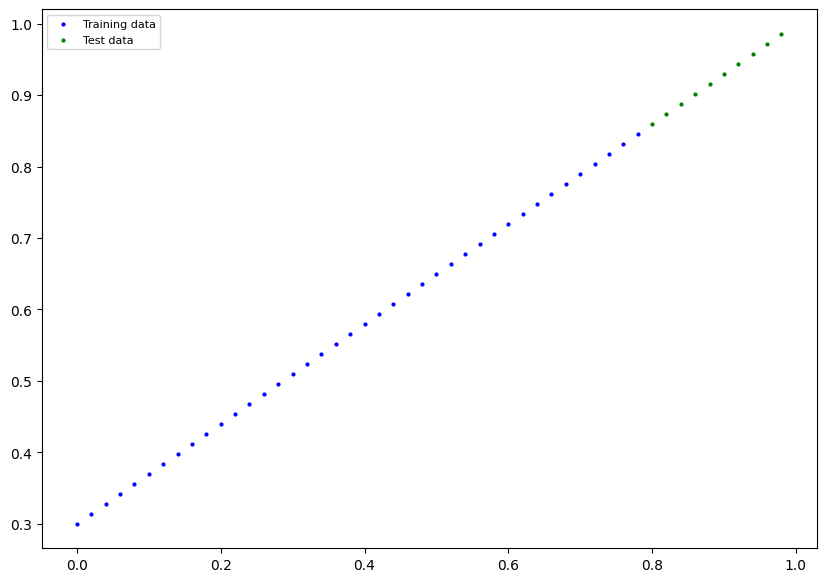

In [177]:
plot_predictions()      #call the function

Building a model (linear regression)

In [178]:
class LinearRegression(nn.Module):                      #creating subclass (child class) which inherits almost everything from the parent class nn.Module
    def __init__(self):
        super().__init__()                              #allows the function to use methods from the parent class
        self.weights = nn.Parameter(torch.rand(1,       #creates a 1dim random value (basically just a single number)
                                               requires_grad=True,      #pytorch will track the gradients of this specific parameter for use with torch.autograd and grad descent (this is usually on by default)
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
        #forward method to defind the computations in the model
    def forward(self,x:torch.tensor)->torch.tensor:     # x is the input data (which is a type of torch.tensor) this method returns a "torch.tensor"
        return self.weights * x + self.bias             #this is the linear regression

Checking the contents of the model (model parameters)

In [179]:
torch.manual_seed(42)

model_0 = LinearRegression()        #create instance of the model

list(model_0.parameters())          #checkout the parameters

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [180]:
model_0.state_dict()            #list named parameters
#shows the initial weight and bias before training

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [181]:
weight, bias            #ideal values 

(0.7, 0.3)

Making predictions with the model

In [182]:
with torch.inference_mode():            #inference mode turns off the gradient tracking --> don't need keep track of the grad rn cuz we are not doing training we are just testing the model
    y_preds = model_0(X_test)           #predictions will be faster for larger data sets as pytorch is keeping track of lesser memory

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

In [183]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

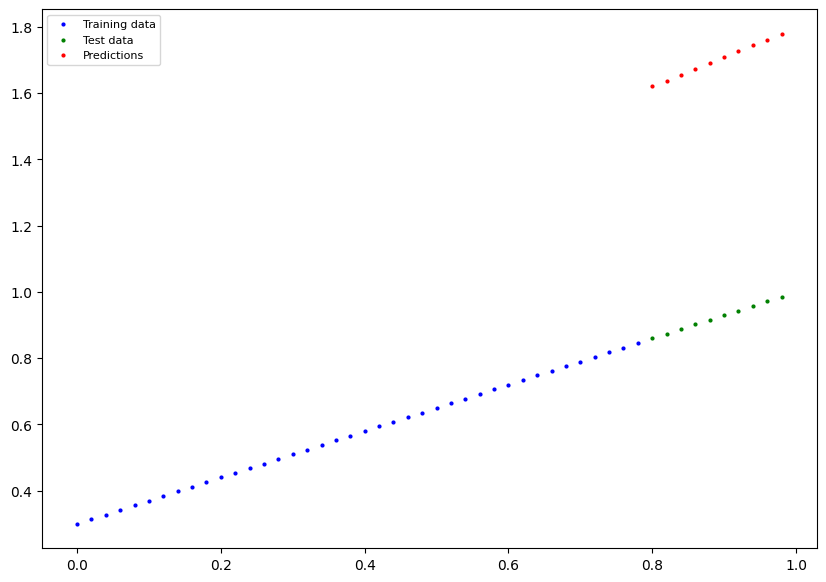

In [184]:
plot_predictions(predictions=y_preds)

In [185]:
#ideally uw the red dots ontop of the green dots or at least close to it 

Training the model

In [186]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [187]:
#check out the models parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [188]:
#setup a loss function
loss_fn = nn.L1Loss()

In [189]:
#setup an optimizer
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.01)

Building a training loop

In [190]:
torch.manual_seed(42)

epoch_count = []
loss_values = []
test_loss_values = []

epochs = 100              #an epoch is 1 loop through the data (this is a hyperparameter as we have set it ourselves)

for epoch in range(epochs):
    model_0.train()         #set as training mode in PyTorch sets all parameters which requires gradients to require gradients

    y_preds = model_0(X_train)          #forward pass

    loss = loss_fn(y_preds,y_train)         #calculate the loss (aka how far off are the parameters)
    print(f"Loss: {loss}")

    optimizer.zero_grad()

    loss.backward()        #perform back propagation on the loss wrt the parameters of the model

    optimizer.step()        #step optimizer (perform gradient descent)->by defult how the optimizer changes will accumulate through the loop so.. 
                            #we have to zero them above in step 3 for the next iteration of the loop

    model_0.eval()          #turns off gradient tracking

    ###TESTING CODE
    model_0.eval()          #turns off different settings in the model not needed for evaulation/testing
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred,y_test)

    if epoch%10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

        print(model_0.state_dict())

Loss: 0.6860889196395874
Epoch: 0 | Loss: 0.6860889196395874 | Test loss: 0.7637526988983154
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Loss: 0.6745679378509521
Loss: 0.6630470156669617
Loss: 0.6515260338783264
Loss: 0.6400049924850464
Loss: 0.6284840703010559
Loss: 0.6169630289077759
Loss: 0.6054420471191406
Loss: 0.5939210653305054
Loss: 0.5824000239372253
Loss: 0.5708791017532349
Epoch: 10 | Loss: 0.5708791017532349 | Test loss: 0.6290428042411804
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Loss: 0.5593580603599548
Loss: 0.5478371381759644
Loss: 0.5363161563873291
Loss: 0.5247951149940491
Loss: 0.5132741332054138
Loss: 0.5017532110214233
Loss: 0.4902321696281433
Loss: 0.47871121764183044
Loss: 0.4671902060508728
Loss: 0.45566922426223755
Epoch: 20 | Loss: 0.45566922426223755 | Test loss: 0.4943329691886902
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Loss: 0.4441482126712799
Loss: 0.43262726068496

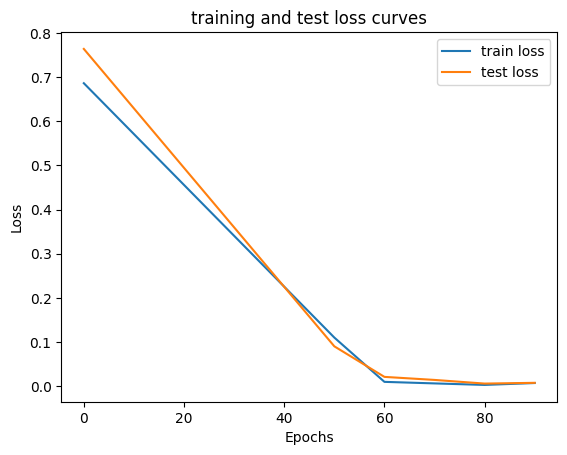

In [200]:
#plto the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="train loss")
plt.plot(epoch_count, test_loss_values, label="test loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [201]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [202]:
with torch.inference_mode():
    y_preds_new=model_0(X_test)         #test the new model

In [203]:
#plot_predictions(predictions=y_preds)

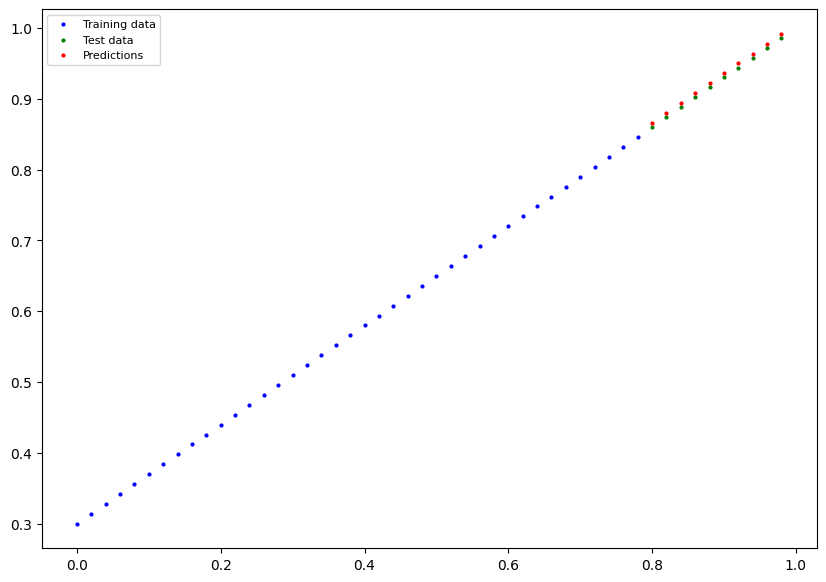

In [204]:
plot_predictions(predictions=y_preds_new)

writing testing loop code

In [205]:
#in the training loop